In [103]:
import pandas as pd

In [104]:
df = pd.read_csv('C:\\Users\\Джойчик\\Desktop\\Cohortanalysys\\sales_apteka.csv', encoding='windows-1251', sep=';')
    

In [105]:
df.head(10)

,datetime,shop,card,bonus_earned,bonus_spent,summ,summ_with_disc,doc_id
0,2021-07-13 12:56:09.000,РђРїС‚РµРєР° 2,2000200195023,51,0,3400,3400,15#2002741#65938#2_29
1,2021-07-30 10:42:00.000,РђРїС‚РµРєР° 2,2000200193494,57,0,747,747,15#2002972#65955#2_5
2,2021-10-11 12:55:23.000,РђРїС‚РµРєР° 2,2000200199106,92,253,3077,3077,15#2004060#66028#2_29
3,2021-10-14 14:48:56.000,РђРїС‚РµРєР° 2,2000200168768,1,0,54,54,15#2004107#66031#2_57
4,2021-10-20 11:09:39.000,РђРїС‚РµРєР° 2,2000200226314,101,0,1733,1733,15#2004192#66037#2_16
5,2021-10-29 13:55:20.000,РђРїС‚РµРєР° 2,2000200192060,8,0,285,285,15#2004318#66046#2_40
6,2021-11-12 14:10:11.000,РђРїС‚РµРєР° 2,2000200193241,17,0,588,588,15#2004481#66060#2_35
7,2021-11-15 12:21:15.000,РђРїС‚РµРєР° 2,2000200183938,33,0,825,825,15#2004513#66063#2_24
8,2021-11-30 18:01:09.000,РђРїС‚РµРєР° 2,2000200165811,26,0,886,886,15#2004712#66078#2_63
9,2021-12-03 15:51:20.000,РђРїС‚РµРєР° 2,2000200186984,6,0,172,172,15#2004764#66081#2_78


In [106]:
# Оставим колонки,нужные для расчёта LTV и присваивоим им более понятные названия
df = df.rename(
    columns={
      "datetime": "created_at",
      "card": "client_id",
      "summ_with_disc": "revenue"
    }
)

df = df[['created_at', 'client_id', 'revenue']]

# Для удобства фильтруем продажи только до 2022 года
df = df[df['created_at'] < '2022-01-01']

In [107]:
df.head(10)

,created_at,client_id,revenue
0,2021-07-13 12:56:09.000,2000200195023,3400
1,2021-07-30 10:42:00.000,2000200193494,747
2,2021-10-11 12:55:23.000,2000200199106,3077
3,2021-10-14 14:48:56.000,2000200168768,54
4,2021-10-20 11:09:39.000,2000200226314,1733
5,2021-10-29 13:55:20.000,2000200192060,285
6,2021-11-12 14:10:11.000,2000200193241,588
7,2021-11-15 12:21:15.000,2000200183938,825
8,2021-11-30 18:01:09.000,2000200165811,886
9,2021-12-03 15:51:20.000,2000200186984,172


In [108]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [109]:
# Определяем когорту - год и месяц первой покупки
df['cohort'] = (
    pd.to_datetime(
        df
        # Для каждого пользователя отдельно отбираем все его покупки
        .groupby('client_id')['created_at']
        # Выбираем самое минимальное дату и время
        .transform('min')
    )
    .dt
    # Приводим к формату ГОД-МЕСЯЦ - это и будет признак когорты
    .strftime('%Y-%m')
)

# Создаем дополнительное поле `created_at2`,
# переводя каждую дату-время каждой покупки также в формат ГОД-МЕСЯЦ
df['created_at2'] = pd.to_datetime(df['created_at']).dt.strftime('%Y-%m')

# Рассчитываем, сколько покупок было совершено каждой когортой в каждом месяце
df = (
    df
    .groupby(['cohort', 'created_at2'])['revenue']
    .agg(revenue='sum')
    .reset_index()
)

# Считаем по каждой когорте нарастающий итог выручки с течением времени
df['cumsum_revenue'] = (
    df
    .sort_values(['cohort', 'created_at2'])
    .groupby('cohort')['revenue']
    .agg(cumsum_revenue='cumsum')
)

# Некоторые когорты могли вообще не делать покупок в некоторые месяцы
# Поэтому дополнительно генерируем последовательность с шагом в 1 месяц
# Начало - самый ранний год-месяц покупки, конец - самый поздний
intervals = pd.date_range(
    df['created_at2'].min(),
    (
        pd.to_datetime(df['created_at2'])
        .apply(lambda x: x + np.timedelta64(1, 'M'))
        .max()
    ),
    freq='m'
).strftime('%Y-%m').to_frame(name='intervals')

# Аналогично генерируем полный список когорт
cohorts = pd.date_range(
    df['cohort'].min(),
    (
        pd.to_datetime(df['cohort'])
        .apply(lambda x: x + np.timedelta64(1, 'M'))
        .max()
    ),
    freq='m'
).strftime('%Y-%m').to_frame(name='cohorts')

# Делаем декартово произведение этих двух наборов данных
# У нас получится таблица со всеми возможными связками "когорта" - "год-месяц покупки"
# Это нужно, чтобы не потерять никого на этапе когортного анализа
intervals_and_cohorts = intervals.merge(cohorts, how='cross')

# Формируем итоговую таблицу, готовясь проводить когортный анализ
df = (
    df
    # Мержим исходный датафрейм с сгенерированной таблицей правым джоином, чтобы не потерять месяца/когорты, в которые не было продаж
    .merge(intervals_and_cohorts, how='right', left_on=['cohort', 'created_at2'], right_on=['cohorts', 'intervals'])
    .sort_values(['cohorts', 'intervals'])
)

# Заполняем пропуски предыдущими значениями - это значит, что для когорты Х не было продаж в месяц Y
# А значит LTV по этой когорте в этот месяц совпадает с предыдущим
df['cumsum_revenue'] = df.groupby('cohorts')['cumsum_revenue'].fillna(method='ffill')

In [110]:
# Формируем таблицу когортного анализа
cohort_analysis = df.pivot_table(
    index='cohorts',
    columns='intervals',
    values='cumsum_revenue',
    aggfunc='max'
)

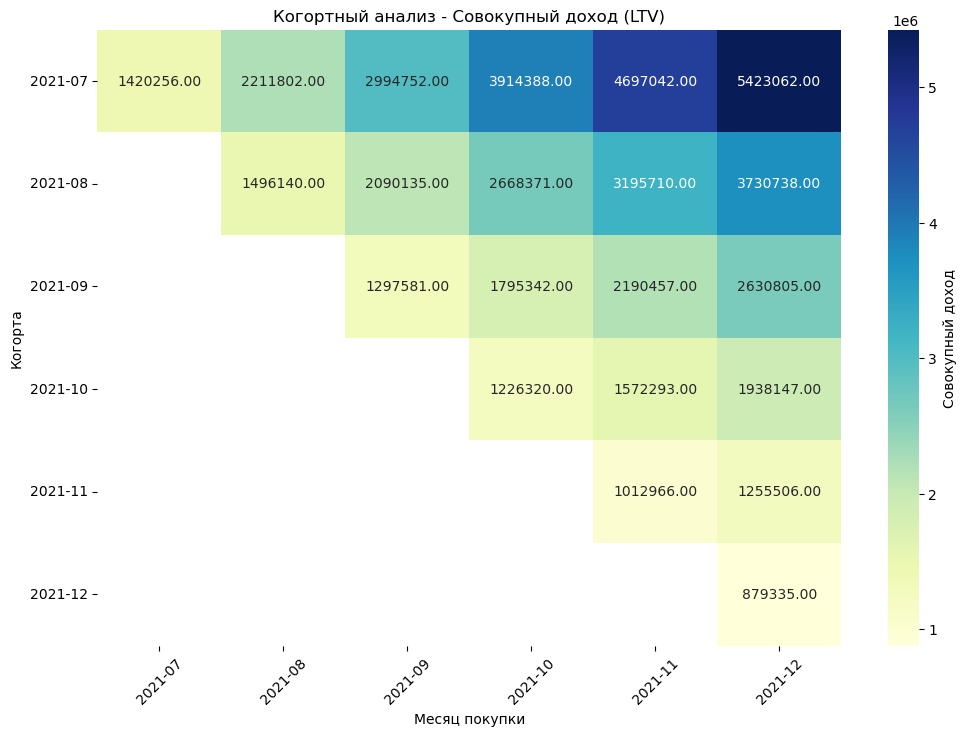

In [111]:
# Создадим тепловую карту
plt.figure(figsize=(12, 8))
sns.heatmap(cohort_analysis, annot=True, fmt=".2f", cmap="YlGnBu", cbar_kws={'label': 'Совокупный доход'})
plt.title('Когортный анализ - Совокупный доход (LTV)')
plt.xlabel('Месяц покупки')
plt.ylabel('Когорта')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.show()